<a href="https://colab.research.google.com/github/tekendrajoshi/CNN-Image_Classification_scratch/blob/main/CNN_2_quickdraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============== DOWNLOAD THE IMAGES ============
import os
import requests

classes = [
    "cat", "dog", "apple", "car", "tree", "house", "bicycle", "airplane",
    "clock", "book", "face", "chair", "cup", "sun", "cloud", "fish",
    "flower", "shoe", "train", "laptop"
]
base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap"
save_dir = "/content/quickdraw_npy"
os.makedirs(save_dir, exist_ok=True)

for cls in classes:
    url = f"{base_url}/{cls}.npy"
    save_path = f"{save_dir}/{cls}.npy"

    if not os.path.exists(save_path):
        print(f"⬇️ Downloading {cls}.npy...")
        r = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(r.content)
    else:
        print(f"✔️ {cls}.npy already exists.")
print("✅ All downloads done.")


⬇️ Downloading cat.npy...
⬇️ Downloading dog.npy...
⬇️ Downloading apple.npy...
⬇️ Downloading car.npy...
⬇️ Downloading tree.npy...
⬇️ Downloading house.npy...
⬇️ Downloading bicycle.npy...
⬇️ Downloading airplane.npy...
⬇️ Downloading clock.npy...
⬇️ Downloading book.npy...
⬇️ Downloading face.npy...
⬇️ Downloading chair.npy...
⬇️ Downloading cup.npy...
⬇️ Downloading sun.npy...
⬇️ Downloading cloud.npy...
⬇️ Downloading fish.npy...
⬇️ Downloading flower.npy...
⬇️ Downloading shoe.npy...
⬇️ Downloading train.npy...
⬇️ Downloading laptop.npy...
✅ All downloads done.


In [2]:
# MAKES COMBINED DATASET WITH 1000 IMAGES EACH FROM ALL 4 CXATEGORIES AND SPLIT THEM INTO TRAIN TEST DATASETS


import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Classes you want to include
classes = [
    "cat", "dog", "apple", "car", "tree", "house", "bicycle", "airplane",
    "clock", "book", "face", "chair", "cup", "sun", "cloud", "fish",
    "flower", "shoe", "train", "laptop"
]
class_labels = {cls: i for i, cls in enumerate(classes)}

X = []
y = []

# Load 1000 samples per class and label
for cls in classes:
    data = np.load(f"/content/quickdraw_npy/{cls}.npy")
    X.append(data[:1000])  # take only first 1000 images
    y.append(np.full(1000, class_labels[cls]))  # e.g., 0 for cat, 1 for dog

# Stack everything together
X = np.concatenate(X, axis=0).reshape(-1, 28, 28, 1) / 255.0  # normalize and reshape
y = np.concatenate(y, axis=0)

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (16000, 28, 28, 1)
y_train shape: (16000,)


In [3]:
import numpy as np

# ===== ReLU =====

# ReLU = Rectified Linear Unit. It replaces all negative values with 0, and keeps positive values unchanged. 📈 Used to add non-linearity to the model.
def relu(x):
    return np.maximum(0, x)



# ===================== MAX POOLING 2x2 with stride 2 ===================================

#Takes a 2x2 region and picks the maximum value (downsampling).
#🔸 Reduces size of image by half → e.g. from (26x26) → (13x13)

def max_pooling(feature_map):          # feature map is the 2D array output got from filter(i.e. RELU bata)
    h, w = feature_map.shape           # shape of the feature map i.e. h=HEIGHT   w= WIDTH
    out = np.zeros((h // 2, w // 2))   #Create an empty array to store the pooled result i.e. yaha half of the inputs: (26, 26)=> (13, 13)


    for i in range(0, h, 2):                 # Loop through the feature map with steps of 2 (stride = 2)
        for j in range(0, w, 2):              # i moves down (rows), j moves right (columns)   So each iteration covers one 2×2 block like this:
            out[i//2, j//2] = np.max(feature_map[i:i+2, j:j+2])          # This line grabs a 2×2 region starting at (i, j)
                                                                          # Then applies np.max() to that 2×2 block → selects maximum value and Places that max value in the output array at position (i//2, j//2)
    return out

# Why i//2, j//2?   ==== Because we are reducing size by half, so every (i,j) in input becomes (i//2, j//2) in output.





# ================== SOFTMAX ===========================

#Converts raw scores into probabilities that add up to 1
#🎯 Used in the output layer to represent confidence for each class (e.g. 20% cat, 80% dog)
#  The softmax function takes a vector of raw scores (called logits) from the output layer and turns them into probabilities that: Are between 0 and 1  and Sum of probabilities of all category is 1

def softmax(x):                  # x is a 1D NumPy array — the output scores from the final layer of the network (before activation)
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)





# ===== Convolution Layer (Single filter)  output= feature map =====

# Applies a filter (kernel) to the image using a sliding window.
# At each position, it multiplies region values and filter weights, adds bias, and stores the result.
# 🧠 This is how CNN "sees" edges, curves, shapes, etc.

def convolve(image, filt, bias):
    h, w = image.shape
    fh, fw = filt.shape    # filter ko height ra width
    out_h = h - fh + 1
    out_w = w - fw + 1
    # (28, 28) => (26, 26)
    # ailesamma output ko height ra width kati hunxa nikalyo and stored in out_h and out_w
    # We’re using valid convolution (no padding), so the output size shrinks.

    out = np.zeros((out_h, out_w))         # Prepares an empty 2D array for the feature map.

    # Initially filled with zeros — we will fill it with convolution results from the following lope
    for i in range(out_h):
        for j in range(out_w):
            region = image[i:i+fh, j:j+fw]
            # Extracts a 3×3 block from the image at position (i, j)
            # For example, if i=5, j=7, this will take the block:
            # image[5:8, 7:10]

            out[i, j] = np.sum(region * filt) + bias
            # Performs element-wise multiplication between region and filter
            # Then sums all the products
            # Adds the bias
            # Stores the result in the output feature map at position (i, j)
    return out
    #  After the loop finishes, out holds the entire convolved image (feature map).






# ===== Fully Connected Layer =====

# Takes a flattened vector (from image) and connects to output neurons.
#  This layer gives raw scores for each class.

def fully_connected(flat_input, weights, bias):
    return np.dot(flat_input, weights) + bias
    # 🔚 Output:
    # Returns a vector of raw scores (logits) — one for each class.
    # You pass this into softmax to convert them into probabilities

In [4]:
# CONVOLUTION LAYER BACKPROPAGATION

def relu_derivative(x):            #ReLU function: f(x) = max(0, x)
    return (x > 0).astype(float)     # Its derivative: 1 if x > 0, else 0

def max_pooling_backward(dout, feature_map):
    h, w = feature_map.shape
    out_h, out_w = h // 2, w // 2
    dinput = np.zeros_like(feature_map)

    for i in range(out_h):
        for j in range(out_w):
            region = feature_map[i*2:i*2+2, j*2:j*2+2]
            max_val = np.max(region)
            for m in range(2):
                for n in range(2):
                    if region[m, n] == max_val:
                        dinput[i*2 + m, j*2 + n] = dout[i, j]
                        break
    return dinput

def convolve_backward(dout, input_img, filt_shape):
    h, w = input_img.shape
    fh, fw = filt_shape
    out_h = h - fh + 1
    out_w = w - fw + 1

    dfilter = np.zeros((fh, fw))
    for i in range(out_h):
        for j in range(out_w):
            region = input_img[i:i+fh, j:j+fw]
            dfilter += region * dout[i, j]
    dbias = np.sum(dout)
    return dfilter, dbias

In [5]:
def forward_pass(image, conv_filters, conv_biases):
    feature_maps = []       # Initialize an empty list to store the output of each filter (i.e., each feature map).   After applying filters, each filter produces a 2D map → we collect all of them here.


    # Loop through all filters and their corresponding biases.
    # conv_filters: list of 2D filters (e.g., 3×3)
    # conv_biases: list of scalar bias values (1 per filter)
    # zip() pairs them
    for f, b in zip(conv_filters, conv_biases):

        fm = convolve(image, f, b)    # Apply your convolve() function to the image using the current filter f and bias b. Output is a 2D feature map (e.g., 26×26

        fm = relu(fm)    # Pass the feature map through the ReLU function.

        fm = max_pooling(fm)      # Applies 2×2 max pooling with stride 2  and Reduces spatial dimensions (from 26×26 to 13×13)

        feature_maps.append(fm)    # Add the current feature map to the list of feature maps.  we will have multiple 13×13 maps each from different filters

    conv_output = np.array(feature_maps) # Convert the list of feature maps into a single NumPy array  Final shape: (num_filters, height, width) → e.g. (8, 13, 13)
                                        # This is the 3D output volume from the convolutional layers

    flat = conv_output.reshape(-1)         # Flattens the 3D output into a 1D vector
    return flat
    # Returns the flattened vector — this is the final output of the convolutional stack (before classification).
    # Next, this gets passed into fully_connected() → softmax() → prediction.





# ======== LOSS FUNCTION =================================

# This function calculates the cross-entropy loss for a single prediction. It measures how far off your model’s predicted probability (preds) is from the correct label.
# preds: A 1D array of predicted probabilities (after softmax), e.g. [0.1, 0.3, 0.2, 0.4]
# label:  The true class index (e.g. 2 if it’s class #2)

def cross_entropy(preds, label):
    epsilon = 1e-10
    return -np.log(preds[label] + epsilon)      # Loss= −log(predicted probability of the correct class)




# ========= CALCULATE DERIVATIVE dL/dz =========================

# This function calculates the gradient of the loss (cross-entropy) with respect to the logits (z) that were passed into the softmax.

def softmax_grad(preds, label):
    grad = preds.copy()
    grad[label] -= 1  # dL/dz = p - y (one-hot)
    return grad

In [7]:
# ==== Data ====
import numpy as np # Import numpy

classes = [
    "cat", "dog", "apple", "car", "tree", "house", "bicycle", "airplane",
    "clock", "book", "face", "chair", "cup", "sun", "cloud", "fish",
    "flower", "shoe", "train", "laptop"
]
n_classes = len(classes)
n_filters = 8               # Each image will be processed through 8 different 3×3 filters.
filter_size = 3
flattened_size = 13 * 13 * n_filters     # flattened_size = 1352 → After convolution and pooling, each image becomes (8, 13, 13) → flatten to 1352-length vector for FC layer.

# ============ Random INITILIZATION ============

# He initialization: scale by sqrt(2 / fan_in)
fan_in = filter_size * filter_size  # For 2D filters (no channels considered here)
he_std = np.sqrt(2. / fan_in)

# Initialize filters and biases

conv_filters = [np.random.randn(3, 3) * np.sqrt(2. / fan_in) for _ in range(n_filters)]
conv_biases = [0.0 for _ in range(n_filters)]
fc_weights = np.random.randn(flattened_size, n_classes) * 0.1  # no of weights = flatterened size(i.e. 13*13 * 8 (no of filters)) * 4 (i.e. no of output classes)
fc_biases = np.zeros(n_classes)     # no of fully connected layers = no of classes and initialize all the biases to 0.

# ==== Training ====
lr = 0.05   #Learning Rate
EPOCHS = 8

for epoch in range(EPOCHS):
    total_loss = 0     # initialize total loss
    correct = 0     # initialize the no of correctly classified images
    X_train, y_train = shuffle(X_train, y_train)  # suffles the images for better working

    for i in range(len(X_train)):     # let(X_train)= no of images in the X_train. ===> This is to lope through all the training images
        img = X_train[i].reshape(28, 28)
        label = y_train[i]            # the label i.e. actual type of that specific images i.e. expected/correct output

        # Forward pass
        flat = forward_pass(img, conv_filters, conv_biases)     # pass thhe image, the weights of all the filters and their biases into forward_pass() function which gives a flattened 1D array ready to pass into fully connected layer.

        logits = fully_connected(flat, fc_weights, fc_biases)   # pass the output 1D array from forward_pass() to fully_connected() along with the weights and biases

        probs = softmax(logits)    # pass the output from fully connected to softmax() to get the probabilities

        # Loss
        loss = cross_entropy(probs, label)  # calculates loss function based on the probabilities and the label
        total_loss += loss
        pred = np.argmax(probs)

        if pred == label:
            correct += 1   # if predicted output is same as label then increment the no of correctly predicted images




        # =========BACKPROPAGATION  (only FC layer)==============================
        grad_softmax = softmax_grad(probs, label)
        grad_w = np.outer(flat, grad_softmax)
        grad_b = grad_softmax

        # ================= Gradient Descent update ================
        fc_weights -= lr * grad_w
        fc_biases -= lr * grad_b



        # FOR BACKWARD PROPAGATION IN CONVOLUTION LAYER***********************************************************************************************************************

        def relu_derivative(x):            #ReLU function: f(x) = max(0, x)
            return (x > 0).astype(float)     # Its derivative: 1 if x > 0, else 0

        def max_pooling_backward(dout, feature_map):
            h, w = feature_map.shape
            out_h, out_w = h // 2, w // 2
            dinput = np.zeros_like(feature_map)

            for i in range(out_h):
                for j in range(out_w):
                    region = feature_map[i*2:i*2+2, j*2:j*2+2]
                    max_val = np.max(region)
                    for m in range(2):
                        for n in range(2):
                            if region[m, n] == max_val:
                                dinput[i*2 + m, j*2 + n] = dout[i, j]
                                break
            return dinput

        def convolve_backward(dout, input_img, filt_shape):
            h, w = input_img.shape
            fh, fw = filt_shape
            out_h = h - fh + 1
            out_w = w - fw + 1

            dfilter = np.zeros((fh, fw))
            for i in range(out_h):
                for j in range(out_w):
                    region = input_img[i:i+fh, j:j+fw]
                    dfilter += region * dout[i, j]
            dbias = np.sum(dout)
            return dfilter, dbias

    acc = correct / len(X_train)
    print(f"📚 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Accuracy: {acc*100:.2f}%")

📚 Epoch 1/8 | Loss: 35968.7361 | Accuracy: 58.87%
📚 Epoch 2/8 | Loss: 27115.9526 | Accuracy: 69.27%
📚 Epoch 3/8 | Loss: 24229.1462 | Accuracy: 71.88%
📚 Epoch 4/8 | Loss: 22554.3084 | Accuracy: 73.78%
📚 Epoch 5/8 | Loss: 20932.4986 | Accuracy: 75.48%
📚 Epoch 6/8 | Loss: 19833.6204 | Accuracy: 76.08%
📚 Epoch 7/8 | Loss: 18704.1271 | Accuracy: 77.49%
📚 Epoch 8/8 | Loss: 18210.6498 | Accuracy: 77.90%


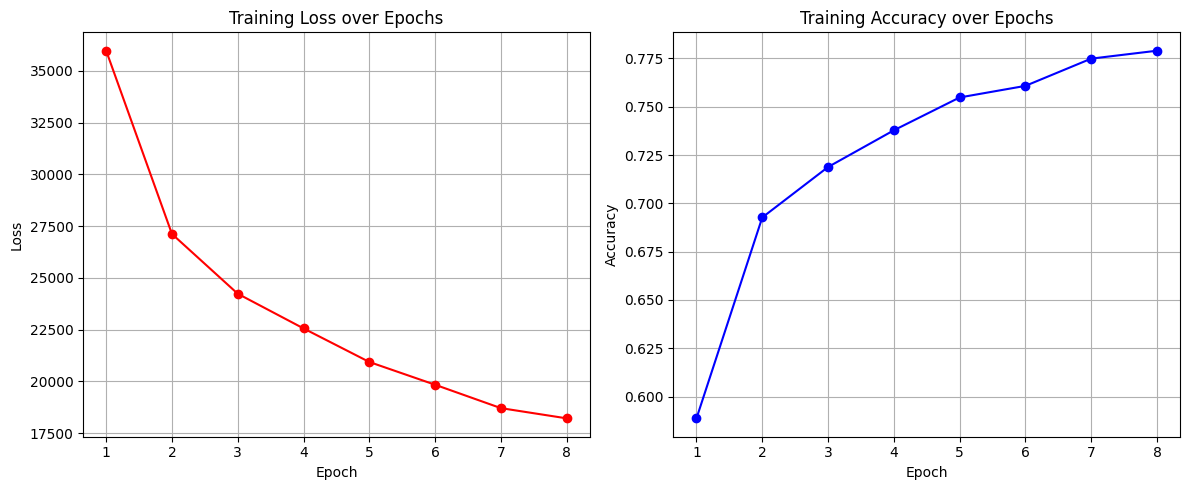

In [16]:
import matplotlib.pyplot as plt

# Extracted from training output
epoch_losses = [35968.7361, 27115.9526, 24229.1462, 22554.3084,
                20932.4986, 19833.6204, 18704.1271, 18210.6498]

# Convert percentage to decimal for plotting from the above output data
epoch_accuracies = [0.5887, 0.6927, 0.7188, 0.7378,
                    0.7548, 0.7608, 0.7749, 0.7790]

# Plotting
epochs = list(range(1, 9))

# Create separate plots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, color='red', marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracies, color='blue', marker='o')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


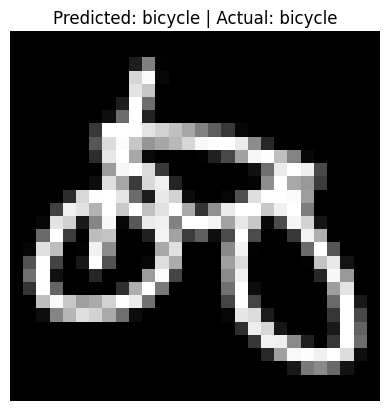

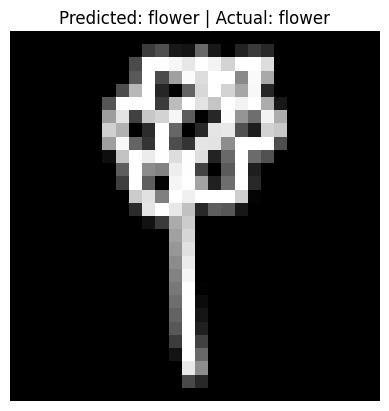

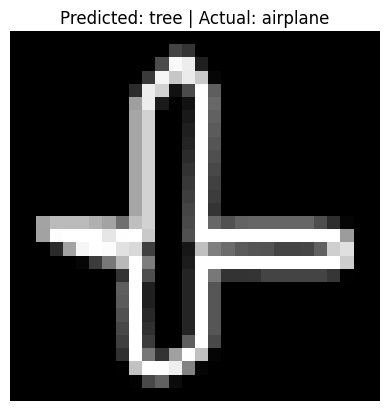

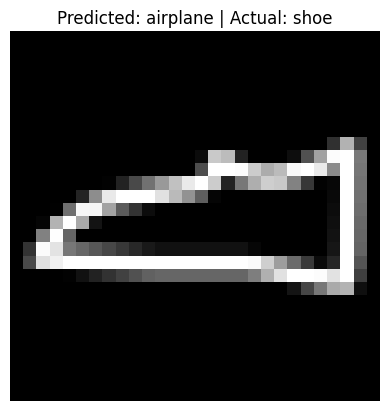

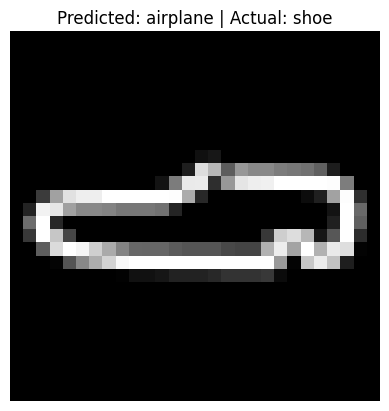

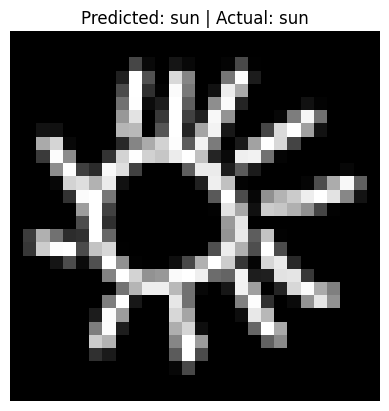

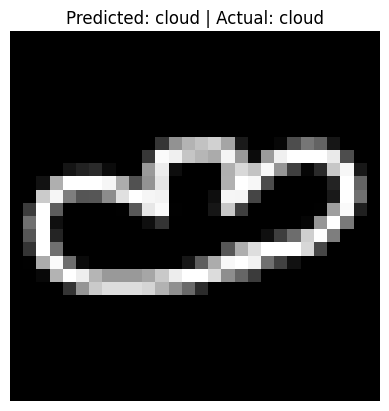

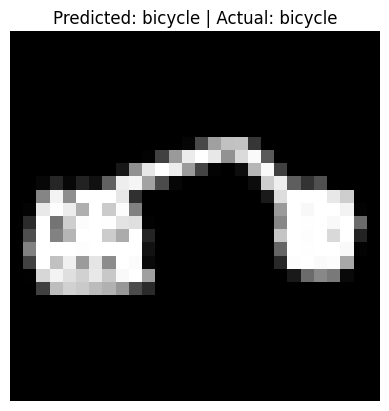

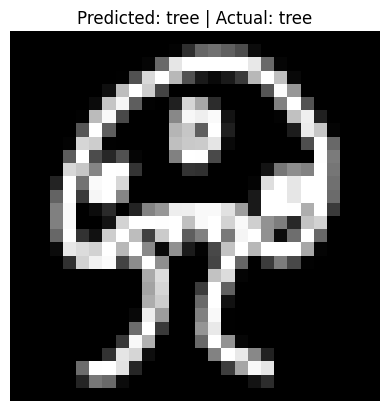

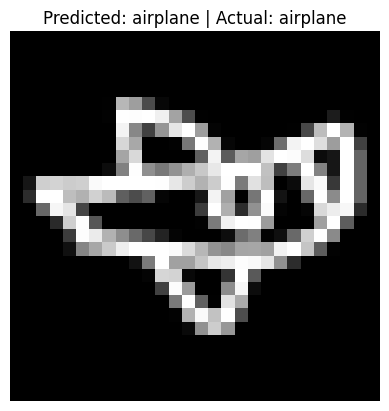

In [10]:


import matplotlib.pyplot as plt

for i in range(10):
    img = X_test[i].reshape(28, 28)
    label = y_test[i]
    pred = np.argmax(softmax(fully_connected(forward_pass(img, conv_filters, conv_biases), fc_weights, fc_biases)))

    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {classes[pred]} | Actual: {classes[label]}")
    plt.axis("off")
    plt.show()



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = []
for img in X_test:
    logits = fully_connected(forward_pass(img.reshape(28, 28), conv_filters, conv_biases), fc_weights, fc_biases)
    probs = softmax(logits)
    y_pred.append(np.argmax(probs))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


KeyboardInterrupt: 

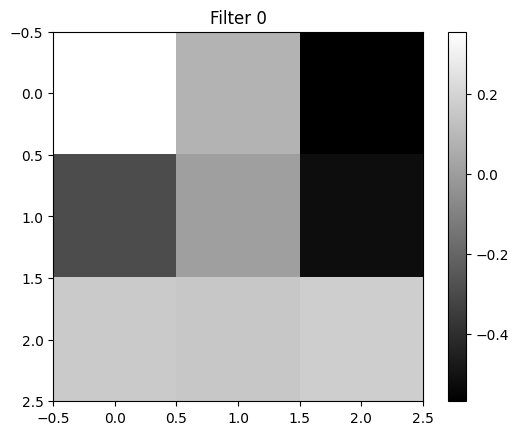

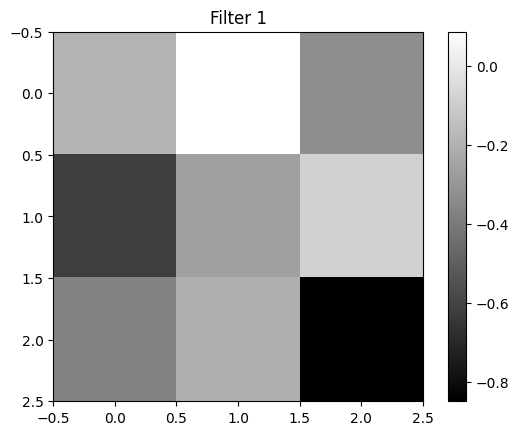

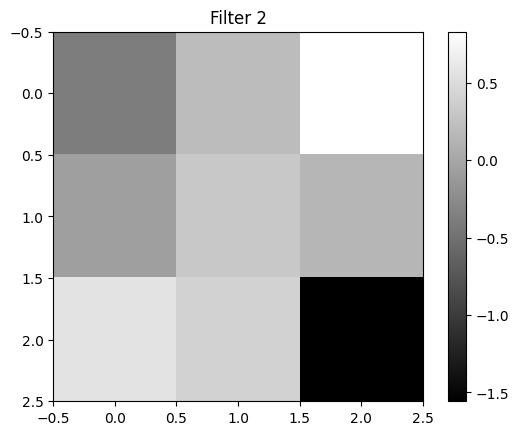

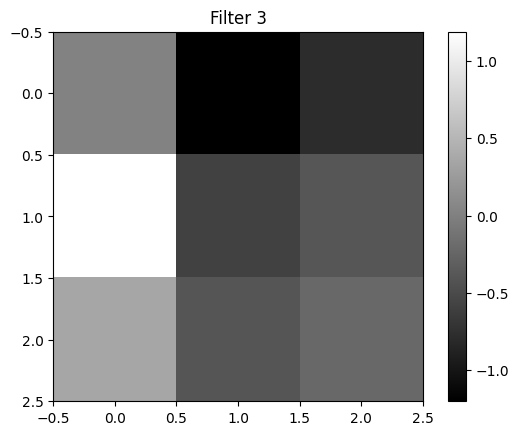

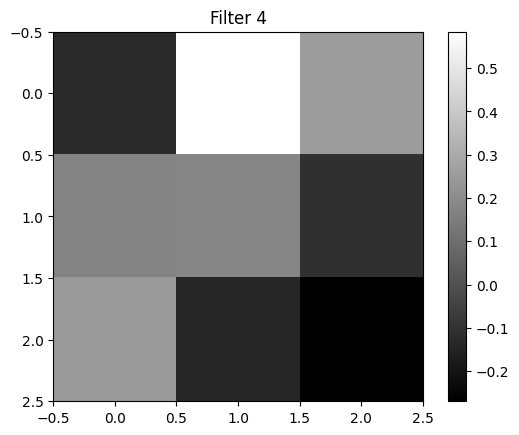

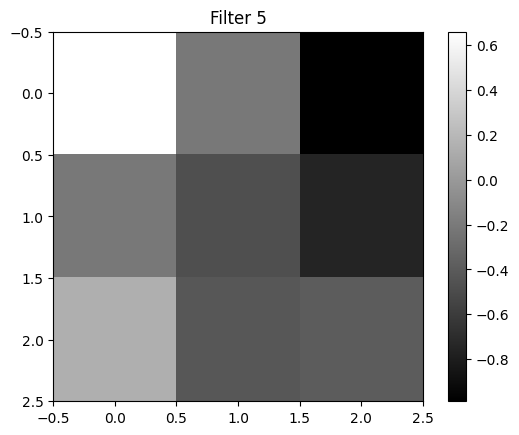

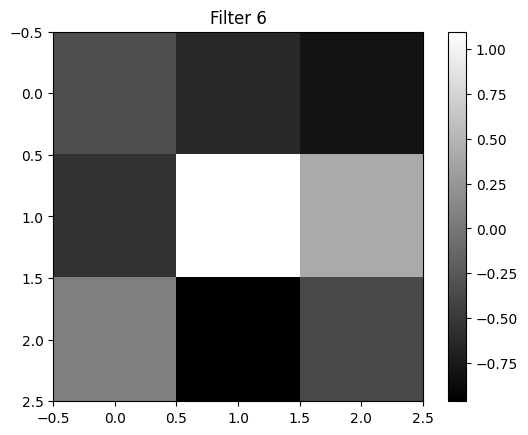

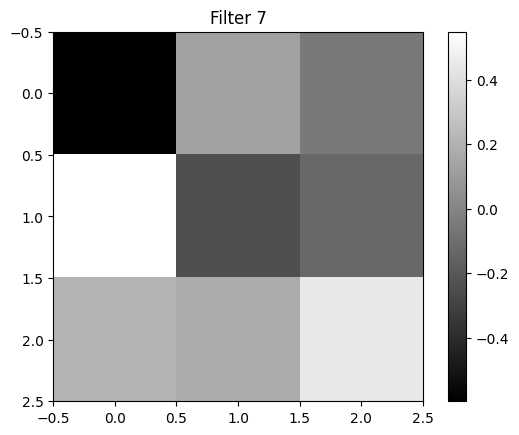

In [12]:
for i, filt in enumerate(conv_filters):
    plt.imshow(filt, cmap='gray')
    plt.title(f"Filter {i}")
    plt.colorbar()
    plt.show()


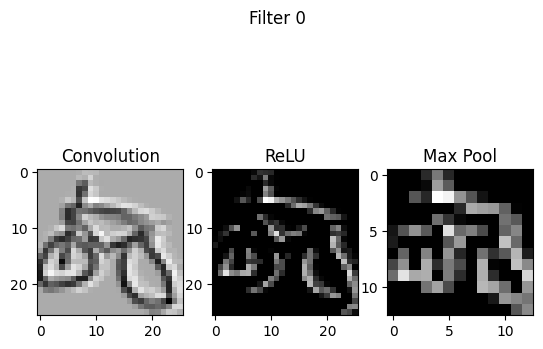

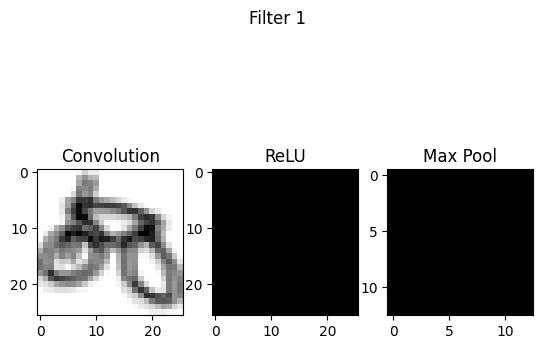

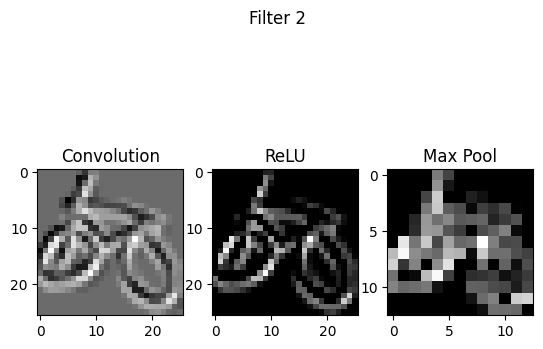

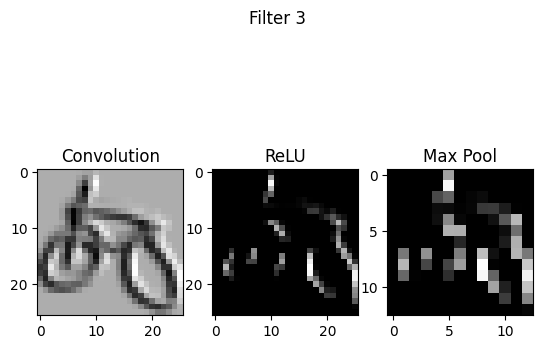

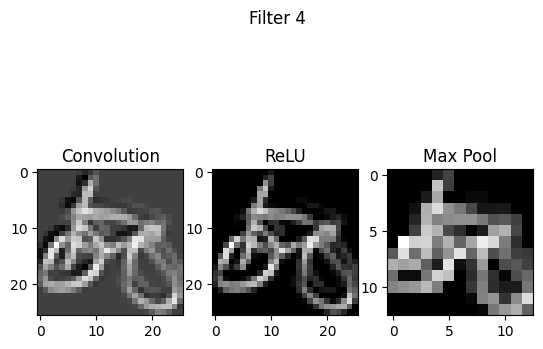

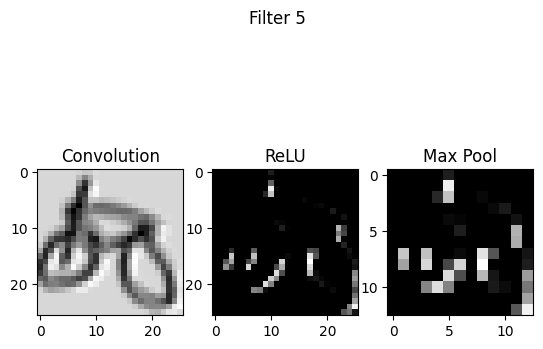

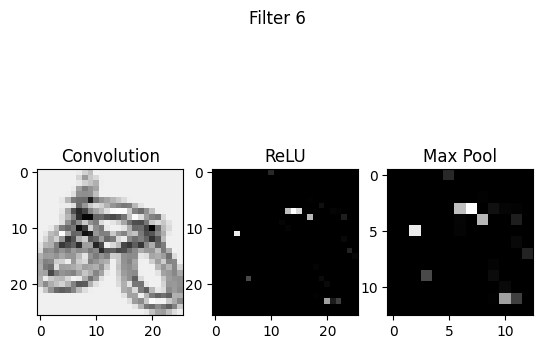

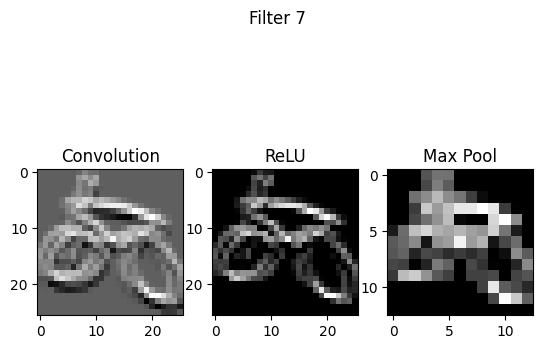

In [13]:
img = X_test[0].reshape(28, 28)
for i, f in enumerate(conv_filters):
    conv = convolve(img, f, conv_biases[i])
    relu_out = relu(conv)
    pooled = max_pooling(relu_out)

    plt.subplot(1, 3, 1)
    plt.imshow(conv, cmap='gray')
    plt.title("Convolution")

    plt.subplot(1, 3, 2)
    plt.imshow(relu_out, cmap='gray')
    plt.title("ReLU")

    plt.subplot(1, 3, 3)
    plt.imshow(pooled, cmap='gray')
    plt.title("Max Pool")

    plt.suptitle(f"Filter {i}")
    plt.show()
